# IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains [covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images].
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Specify training data directory
XRay_Directory = '/content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department/Dataset'

In [4]:
# List the folders in the directory
os.listdir(XRay_Directory)

['3', '2', '0', '1']

In [5]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)

In [6]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(XRay_Directory, target_size=(256, 256), batch_size=40, shuffle=True, class_mode='categorical', subset='training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(XRay_Directory, target_size=(256, 256), batch_size=40, shuffle=True, class_mode='categorical', subset='validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]],

In [12]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

# VISUALIZE DATASET

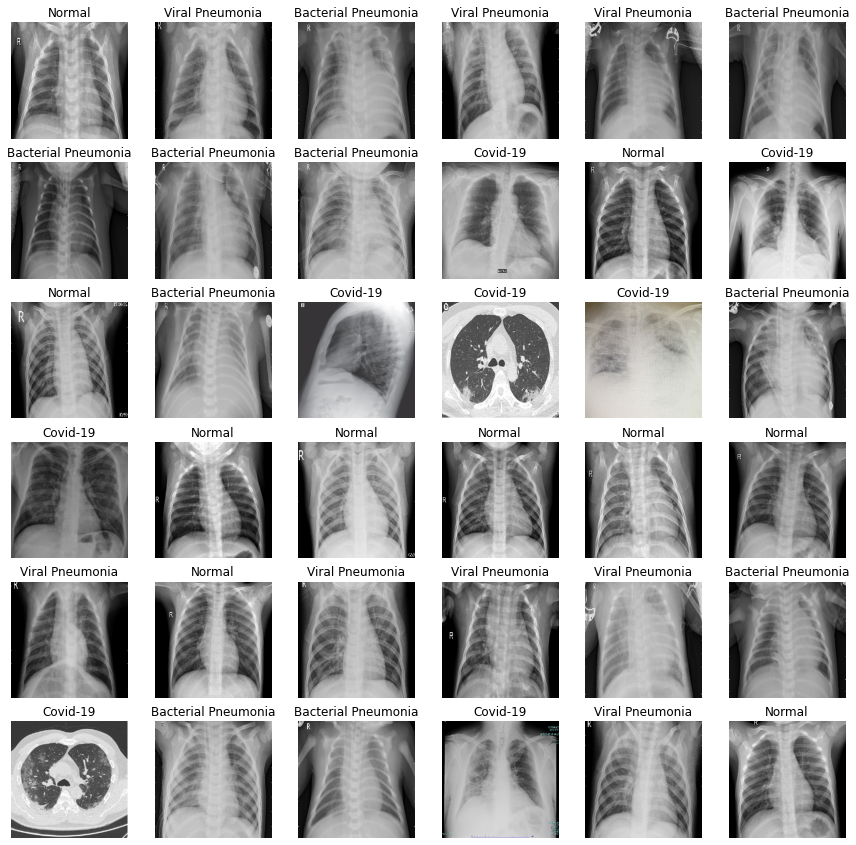

In [13]:
plt.figure(figsize=(15, 15))
for i in range(36):
  plt.subplot(6,6,i+1)
  plt.imshow(train_images[i])
  plt.title(label_names[np.argmax(train_labels[i])])
  plt.axis('off')


# IMPORT MODEL WITH PRETRAINED WEIGHTS

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 1s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [17]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# BUILD AND TRAIN DEEP LEARNING MODEL

In [18]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department', verbose=1, save_best_only=True)


In [43]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [22]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 20, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

<ipython-input-22-b00a6933fa1a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 20, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])


Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7033
Epoch 1: val_loss improved from inf to 3.71182, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 139s 1s/step - loss: 0.8121 - accuracy: 0.7033 - val_loss: 3.7118 - val_accuracy: 0.2500
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8692
Epoch 2: val_loss did not improve from 3.71182
107/107 [==============================] - 14s 129ms/step - loss: 0.4420 - accuracy: 0.8692 - val_loss: 7.7627 - val_accuracy: 0.2500
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.9136
Epoch 3: val_loss did not improve from 3.71182
107/107 [==============================] - 14s 129ms/step - loss: 0.2613 - accuracy: 0.9136 - val_loss: 20.8430 - val_accuracy: 0.2500
Epoch 4/20
107/107 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9206
Epoch 4: val_loss did not improve from 3.71182
107/107 [==============================] - 14s 130ms/step - loss: 0.2813 - accuracy: 0.9206 - val_loss: 28.1675 - val_accuracy: 0.2500
Epoch 5/20
107/107 [===============

107/107 [==============================] - 33s 308ms/step - loss: 0.0238 - accuracy: 0.9907 - val_loss: 3.4280 - val_accuracy: 0.2885
Epoch 9/20
107/107 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9720
Epoch 9: val_loss did not improve from 3.42802
107/107 [==============================] - 14s 128ms/step - loss: 0.2143 - accuracy: 0.9720 - val_loss: 5.1439 - val_accuracy: 0.3654
Epoch 10/20
107/107 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9720
Epoch 10: val_loss did not improve from 3.42802
107/107 [==============================] - 14s 131ms/step - loss: 0.1302 - accuracy: 0.9720 - val_loss: 7.3053 - val_accuracy: 0.5000
Epoch 11/20
107/107 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9883
Epoch 11: val_loss improved from 3.42802 to 1.09831, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 32s 305ms/step - loss: 0.0339 - accuracy: 0.9883 - val_loss: 1.0983 - val_accuracy: 0.7500
Epoch 12/20
107/107 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9790
Epoch 12: val_loss did not improve from 1.09831
107/107 [==============================] - 14s 134ms/step - loss: 0.1193 - accuracy: 0.9790 - val_loss: 3.7433 - val_accuracy: 0.6250
Epoch 13/20
107/107 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9883
Epoch 13: val_loss improved from 1.09831 to 0.65919, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 33s 308ms/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 0.6592 - val_accuracy: 0.9519
Epoch 14/20
107/107 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9836
Epoch 14: val_loss improved from 0.65919 to 0.59031, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 33s 305ms/step - loss: 0.0705 - accuracy: 0.9836 - val_loss: 0.5903 - val_accuracy: 0.8558
Epoch 15/20
107/107 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 15: val_loss improved from 0.59031 to 0.42167, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 34s 315ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.9423
Epoch 16/20
107/107 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9930
Epoch 16: val_loss did not improve from 0.42167
107/107 [==============================] - 14s 131ms/step - loss: 0.0611 - accuracy: 0.9930 - val_loss: 0.7520 - val_accuracy: 0.9231
Epoch 17/20
107/107 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9977
Epoch 17: val_loss did not improve from 0.42167
107/107 [==============================] - 15s 142ms/step - loss: 0.0068 - accuracy: 0.9977 - val_loss: 0.6776 - val_accuracy: 0.9327
Epoch 18/20
107/107 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9977
Epoch 18: val_loss improved from 0.42167 to 0.26594, saving model to /content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department


107/107 [==============================] - 33s 306ms/step - loss: 0.0053 - accuracy: 0.9977 - val_loss: 0.2659 - val_accuracy: 0.9423
Epoch 19/20
107/107 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.9977
Epoch 19: val_loss did not improve from 0.26594
107/107 [==============================] - 15s 136ms/step - loss: 0.0022 - accuracy: 0.9977 - val_loss: 0.4405 - val_accuracy: 0.9712
Epoch 20/20
107/107 [==============================] - ETA: 0s - loss: 5.7259e-06 - accuracy: 1.0000
Epoch 20: val_loss did not improve from 0.26594
107/107 [==============================] - 14s 126ms/step - loss: 5.7259e-06 - accuracy: 1.0000 - val_loss: 0.4846 - val_accuracy: 0.9712


# EVALUATE TRAINED DEEP LEARNING MODEL

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

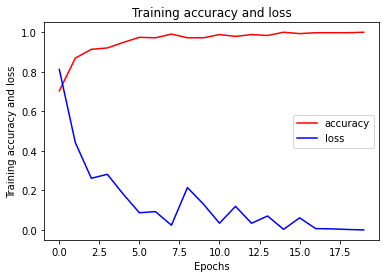

In [24]:
plt.plot(history.history['accuracy'], color='r', label="accuracy")
plt.plot(history.history['loss'], color='b', label='loss')

plt.title('Training accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')
plt.legend()

Text(0, 0.5, 'validation accuracy')

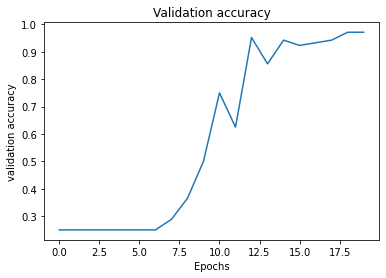

In [25]:
plt.plot(history.history['val_accuracy'])

plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('validation accuracy')

Text(0, 0.5, 'validation loss')

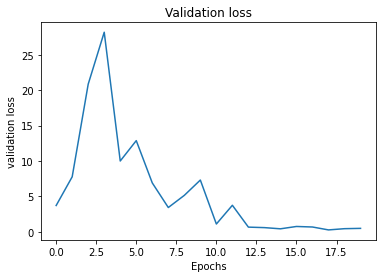

In [26]:
plt.plot(history.history['val_loss'])

plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('validation loss')

In [27]:
test_directory = '/content/drive/MyDrive/Colab Notebooks/Data/Data Science for Business/4. Operations Department/Test'

In [28]:
test_generator = ImageDataGenerator(rescale = 1/255)
test_data = image_generator.flow_from_directory(test_directory, target_size=(256, 256), batch_size=40, shuffle=True, class_mode='categorical')

Found 40 images belonging to 4 classes.


In [29]:
evaluate = model.evaluate_generator(test_data, steps= test_data.n // 4, verbose=1)

<ipython-input-29-2bee0fe82fcd>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_data, steps= test_data.n // 4, verbose=1)


 1/10 [==>...........................] - ETA: 19s - loss: 1.8566 - accuracy: 0.8750

10/10 [==============================] - 2s 34ms/step - loss: 1.8566 - accuracy: 0.8750


In [30]:
evaluate

[1.8565765619277954, 0.875]

In [31]:
print('Accuracy Test : {}'.format(evaluate[1]))

Accuracy Test : 0.875


In [32]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img, (256, 256))
    image.append(image)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 22ms/step


In [33]:
len(original)

40

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.85


In [35]:
# plt.figure(figsize=(15, 15))
# for i in range(36):
#   plt.subplot(6,6,i+1)
#   plt.imshow(image[i])
#   plt.title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
#   plt.axis('off')

In [36]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.67      1.00      0.80        10
           2       1.00      0.60      0.75        10
           3       1.00      0.80      0.89        10

    accuracy                           0.85        40
   macro avg       0.89      0.85      0.85        40
weighted avg       0.89      0.85      0.85        40



Text(0.5, 1.0, 'Confusion_matrix')

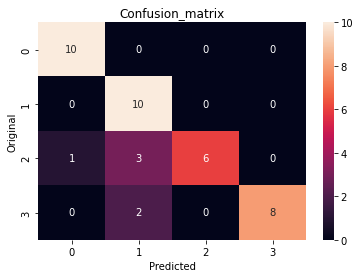

In [37]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# EXCELLENT JOB! YOU SHOULD BE PROUD OF YOUR NEWLY ACQUIRED SKILLS